# Recommender Systems 2021/2022

## Practice - Hybrid Recommenders

### There are several strategies you can adopt to create hybrid models
* Stacking URM, ICM, UCM
* Combine already available models all with the same model structure
* Combine already available models with different model structure
* Combine already available models with rating prediction vs ranking loss functions
* User-wise discrimination

## Some basic information about hybrid models

### The way to go to achieve the best recommendation quality
In order to create an effective hybrid model you need a few things:
* Reasonably well performing models
* Models must look at the task in (at least slightly) different ways
* It must be possible to combine the two

There are many different types of hybrids, we will be covering only some of them.


### In Movielens10M we have the usual URM, but also several ICMs

In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_year, Value range: 6.00E+00 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




In [2]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff_list=[5, 10, 15]

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 69646 ( 0.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions


# Stacking

A simple idea is to look at both iteractions and features as a similar type of information. Given an item, you can see the users that interacted with it as *features* of that item, in the same way as its genre.

To do so, you can concatenate URM and ICM in a single data structure of shape |n_users + n_features|x|n_items|

WARNING: You are creating a new matrix that can be used as URM or ICM interchangeably and plugged into any model you already have. This gives you flexibility but requires caution, for example, what happens if you use that stacked URM in a UserBasedKNN vs in an ItemBasedKNN? (hint: only in one it makes sense)

In [3]:
import scipy.sparse as sps

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

stacked_URM = sps.vstack([URM_train, ICM_genres.T])
stacked_URM = sps.csr_matrix(stacked_URM)

stacked_ICM = sps.csr_matrix(stacked_URM.T)

stacked_URM, stacked_ICM

(<69898x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>,
 <10681x69898 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>)

At this point you can use it to train any model you have. Suggestions:
* If one of the two is much larger than the other (like in this case, 60k users vs 20 features) the smaller will be overwhelmed numerically. Add a weight to the smaller one to increase its importance (will only work for models that allow explicit interactions, will not work with models that use implicit ones)
* If the ICM has a bad recommendation quality, maybe stacking will not help
* When computing a item-based similarity, you can also use only *some* of the features or users. This is called feature selection and is a wide area of research.

In [4]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_ItemKNNCF = ItemKNNCFRecommender(stacked_URM)
recommender_ItemKNNCF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCF)
result_df

Similarity column 10681 (100.0%), 1076.58 column/sec. Elapsed time 9.92 sec
EvaluatorHoldout: Processed 69646 (100.0%) in 1.62 min. Users per second: 718


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213253,0.223654,0.090133,0.137016,0.142748,0.387003,0.171549,0.12671,0.627832,0.517077,...,0.115439,0.99668,0.625748,0.021305,8.02565,0.993455,0.108092,0.707789,1.695428,0.045324
10,0.189017,0.235871,0.153523,0.099115,0.11995,0.405532,0.188906,0.169431,0.763317,0.624667,...,0.146522,0.99668,0.760783,0.024737,8.293546,0.995087,0.125504,0.731415,1.617162,0.091378
15,0.172708,0.261391,0.203796,0.080864,0.115911,0.41017,0.205458,0.186968,0.821799,0.679441,...,0.167494,0.99668,0.81907,0.027453,8.471644,0.995897,0.139287,0.747122,1.559834,0.137926


In [5]:
recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, stacked_ICM)
recommender_ItemKNNCBF.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCBF)
result_df

ItemKNNCBFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 1085.69 column/sec. Elapsed time 9.84 sec
EvaluatorHoldout: Processed 69646 (100.0%) in 1.65 min. Users per second: 703


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213253,0.223654,0.090133,0.137016,0.142748,0.387003,0.171549,0.12671,0.627832,0.517077,...,0.115439,0.99668,0.625748,0.021305,8.02565,0.993459,0.109459,0.708695,1.695245,0.045501
10,0.189017,0.235871,0.153523,0.099115,0.11995,0.405532,0.188906,0.169431,0.763317,0.624667,...,0.146522,0.99668,0.760783,0.024737,8.293546,0.995091,0.127091,0.732351,1.616967,0.091736
15,0.172708,0.261391,0.203796,0.080864,0.115911,0.41017,0.205458,0.186968,0.821799,0.679441,...,0.167494,0.99668,0.81907,0.027453,8.471644,0.995901,0.141049,0.748078,1.559632,0.138468


The framework already includes a model that does stacking, but only applied to the KNNs

In [6]:
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_ItemKNNCFCBF.fit(ICM_weight = 10.0)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_ItemKNNCFCBF)
result_df

ItemKNN_CFCBF_HybridRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 1153.32 column/sec. Elapsed time 9.26 sec
EvaluatorHoldout: Processed 69646 (100.0%) in 1.60 min. Users per second: 726


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213336,0.22373,0.090132,0.137114,0.142818,0.387908,0.171641,0.126725,0.628823,0.517806,...,0.113004,0.99668,0.626735,0.021337,8.033252,0.993491,0.109624,0.709366,1.692878,0.045522
10,0.189139,0.23589,0.153386,0.099237,0.120011,0.406332,0.188902,0.169397,0.763619,0.625517,...,0.1395,0.99668,0.761084,0.024629,8.296197,0.99511,0.126538,0.732585,1.615585,0.091759
15,0.172768,0.261476,0.203865,0.080958,0.115966,0.410938,0.205529,0.187033,0.821612,0.680301,...,0.156072,0.99668,0.818884,0.027193,8.469274,0.99591,0.139712,0.747869,1.559417,0.138467


# Hybrid of models with the same structure

The underlying idea is that if you have some models with the same underlying structure, you can merge them in a single one. The result is to define a function that give the various model's parameters creates a new model with its own parameters.
In this example we will see how to combine different item-item similarity models in a new one.

In particular: `ItemKNNCFRecommender` and `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.


In [7]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit()

ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 1157.88 column/sec. Elapsed time 9.22 sec


In [8]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

P3alphaRecommender: URM Detected 56 ( 0.5%) items with no interactions.


Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [9]:
itemKNNCF.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 531003 stored elements in Compressed Sparse Row format>

In [10]:
P3alpha.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 199483 stored elements in Compressed Sparse Row format>

When we create hybrids we always have to account for:
* A weight, which is a hyperparameter to tune. 
* What is the range and distribution of the values we are merging

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

In [11]:
alpha = 0.7
new_similarity = (1 - alpha) * itemKNNCF.W_sparse + alpha * P3alpha.W_sparse
new_similarity

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 711000 stored elements in Compressed Sparse Row format>

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

The framework includes a recommender class which supports a custom similarity

In [12]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNNCustomSimilarityRecommender: URM Detected 56 ( 0.5%) items with no interactions.
EvaluatorHoldout: Processed 69646 (100.0%) in 1.68 min. Users per second: 691


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.215409,0.226058,0.091519,0.138712,0.144573,0.390276,0.174329,0.12846,0.63135,0.52256,...,0.112817,0.99668,0.629254,0.020315,7.935157,0.992767,0.104375,0.700704,1.742755,0.045313
10,0.190391,0.237977,0.155324,0.100197,0.121481,0.408667,0.191664,0.171079,0.766074,0.630482,...,0.144649,0.99668,0.763531,0.023811,8.224321,0.994692,0.122335,0.726238,1.65526,0.091417
15,0.173678,0.263674,0.205994,0.081665,0.117453,0.413189,0.208232,0.188461,0.823077,0.685336,...,0.165247,0.99668,0.820344,0.026533,8.411696,0.995614,0.13632,0.742784,1.592826,0.138028


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 1038.42 column/sec. Elapsed time 10.29 sec
ItemKNNCBFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 6840.25 column/sec. Elapsed time 1.56 sec
ItemKNN_CFCBF_HybridRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 1120.06 column/sec. Elapsed time 9.54 sec


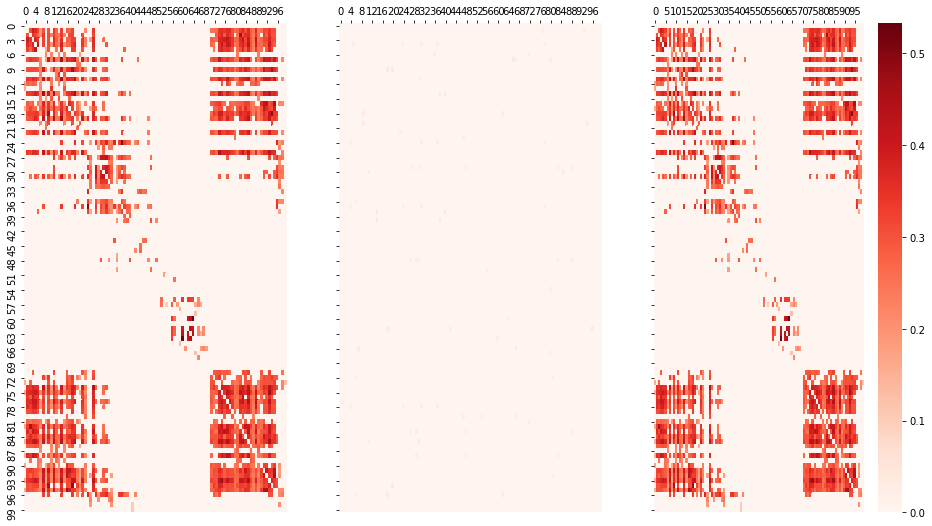

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


recommender_ItemKNNCF = ItemKNNCFRecommender(URM_train)
recommender_ItemKNNCF.fit()

recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_genres)
recommender_ItemKNNCBF.fit()

recommender_ItemKNNCFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_ItemKNNCFCBF.fit()

cf_sim = recommender_ItemKNNCF.W_sparse
cbf_sim = recommender_ItemKNNCBF.W_sparse
cfcbf_sim = recommender_ItemKNNCFCBF.W_sparse

cf_sim_max = cf_sim.max()
cbf_sim_max = cbf_sim.max()
cfcbf_sim_max = cfcbf_sim.max()
vmax = np.max([cf_sim_max, cbf_sim_max, cfcbf_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(cbf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
sns.heatmap(cfcbf_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

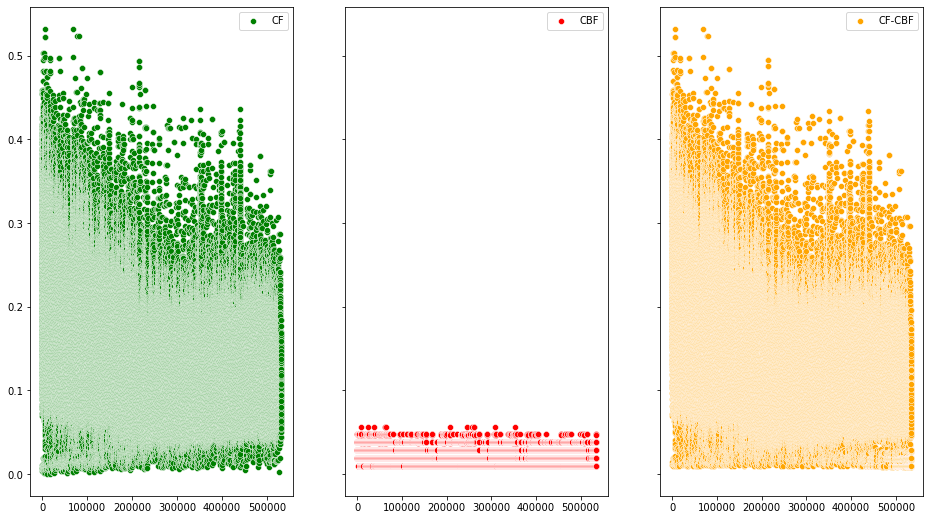

In [14]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
sns.scatterplot(data=cbf_sim.data, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_sim.data, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


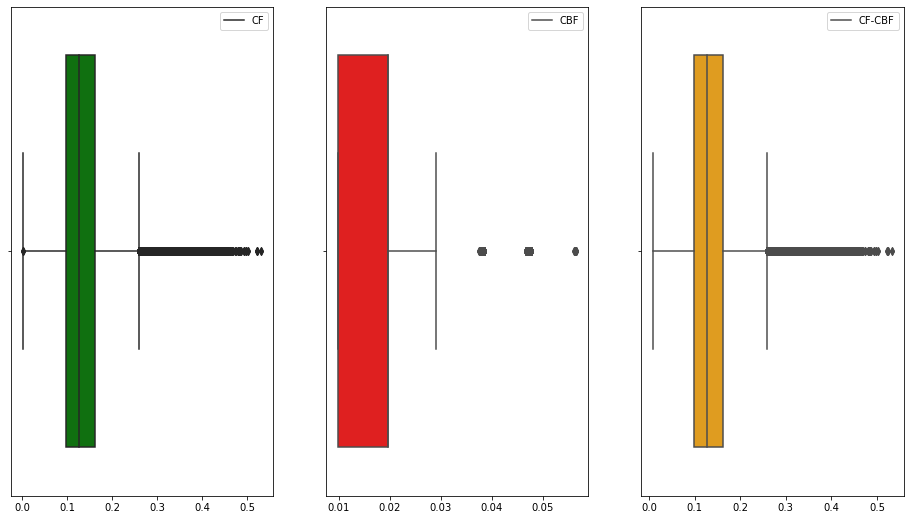

In [15]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=cbf_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=cfcbf_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

# Hybrid of models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In this case we cannot combine the model parameters themselves, rather we can combine the *predictions*.

In [16]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

PureSVDRecommender: URM Detected 56 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.26 sec


We can combine the predictions via a weighted average

In [17]:
user_id = 50

item_scores_itemknn = itemKNNCF._compute_item_score(user_id)
item_scores_itemknn

array([[ 1.5751346, 15.212906 , 15.825802 , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [18]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)
item_scores_puresvd

array([0.00926975, 0.85355353, 0.85023683, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

Again we use a weight

In [19]:
alpha = 0.7

new_item_scores = alpha * item_scores_itemknn + (1 - alpha) * item_scores_puresvd
new_item_scores

array([[ 1.1053752, 10.9051   , 11.333132 , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

Now we create a recommeder class. Note that again we can build a hybrid combining any number of models

In [20]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):
        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [21]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha = 0.5)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ScoresHybridRecommender: URM Detected 56 ( 0.5%) items with no interactions.
EvaluatorHoldout: Processed 69646 (100.0%) in 1.65 min. Users per second: 702


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.215409,0.226058,0.091519,0.138712,0.144573,0.390276,0.174329,0.12846,0.63135,0.52256,...,0.112817,0.99668,0.629254,0.020315,7.935157,0.992767,0.104375,0.700704,1.742755,0.045313
10,0.190391,0.237977,0.155324,0.100197,0.121481,0.408667,0.191664,0.171079,0.766074,0.630482,...,0.144649,0.99668,0.763531,0.023811,8.224321,0.994692,0.122335,0.726238,1.65526,0.091417
15,0.173678,0.263674,0.205994,0.081665,0.117453,0.413189,0.208232,0.188461,0.823077,0.685336,...,0.165247,0.99668,0.820344,0.026533,8.411696,0.995614,0.13632,0.742784,1.592826,0.138028


# Models with rating prediction vs ranking loss functions

Sometimes we have models that optimize different loss functions, one BPR (ranking) and another rating prediction (MSE). For instance:
- SLIMBPR and SLIM EN/MSE
- FunkSVD and MFBPR
- ...

This brings another important problem, for rank-based models there is no clear meaning for the *absolute value* of the prediction. A value of 15.245 may be low or high, depending on the *other* values.

In those cases it becomes essential to include a *normalization* on the weights, to ensure that the values are, at least, in the same range for all models. Many normalizations can be used: min/max, l1, l2, other nonlinear functions (sigmoid, ...)


In [22]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_FunkSVD_Cython

funk_svd_recommender = MatrixFactorization_FunkSVD_Cython(URM_train)
funk_svd_recommender.fit(epochs=200)

MatrixFactorization_FunkSVD_Cython_Recommender: URM Detected 56 ( 0.5%) items with no interactions.
FUNK_SVD: Processed 6401000 (100.0%) in 7.10 sec. MSE loss 2.15E+00. Sample per second: 901174
FUNK_SVD: Epoch 1 of 200. Elapsed time 6.22 sec
FUNK_SVD: Processed 6401000 (100.0%) in 6.08 sec. MSE loss 1.13E+00. Sample per second: 1052665
FUNK_SVD: Epoch 2 of 200. Elapsed time 12.20 sec
FUNK_SVD: Processed 6401000 (100.0%) in 6.09 sec. MSE loss 1.13E+00. Sample per second: 1051602
FUNK_SVD: Epoch 3 of 200. Elapsed time 18.21 sec
FUNK_SVD: Processed 6401000 (100.0%) in 5.73 sec. MSE loss 1.13E+00. Sample per second: 1117830
FUNK_SVD: Epoch 4 of 200. Elapsed time 23.85 sec
FUNK_SVD: Processed 6401000 (100.0%) in 6.67 sec. MSE loss 1.12E+00. Sample per second: 959746
FUNK_SVD: Epoch 5 of 200. Elapsed time 29.79 sec
FUNK_SVD: Processed 6401000 (100.0%) in 6.50 sec. MSE loss 1.12E+00. Sample per second: 984937
FUNK_SVD: Epoch 6 of 200. Elapsed time 35.62 sec
FUNK_SVD: Processed 6401000 (100.0

FUNK_SVD: Epoch 57 of 200. Elapsed time 5.77 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.77 sec. MSE loss 1.05E+00. Sample per second: 823748
FUNK_SVD: Epoch 58 of 200. Elapsed time 5.88 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.20 sec. MSE loss 1.05E+00. Sample per second: 888612
FUNK_SVD: Epoch 59 of 200. Elapsed time 5.99 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.50 sec. MSE loss 1.05E+00. Sample per second: 985293
FUNK_SVD: Epoch 60 of 200. Elapsed time 6.09 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.81 sec. MSE loss 1.05E+00. Sample per second: 939907
FUNK_SVD: Epoch 61 of 200. Elapsed time 6.20 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.00 sec. MSE loss 1.05E+00. Sample per second: 914107
FUNK_SVD: Epoch 62 of 200. Elapsed time 6.30 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.19 sec. MSE loss 1.05E+00. Sample per second: 1033445
FUNK_SVD: Epoch 63 of 200. Elapsed time 6.41 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.02 sec. MSE loss 1.05E+00. Sample per second

FUNK_SVD: Epoch 114 of 200. Elapsed time 11.68 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.14 sec. MSE loss 1.02E+00. Sample per second: 896300
FUNK_SVD: Epoch 115 of 200. Elapsed time 11.79 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.22 sec. MSE loss 1.02E+00. Sample per second: 1029677
FUNK_SVD: Epoch 116 of 200. Elapsed time 11.89 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.11 sec. MSE loss 1.02E+00. Sample per second: 1047576
FUNK_SVD: Epoch 117 of 200. Elapsed time 11.99 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.26 sec. MSE loss 1.02E+00. Sample per second: 1021693
FUNK_SVD: Epoch 118 of 200. Elapsed time 12.09 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.17 sec. MSE loss 1.02E+00. Sample per second: 1036900
FUNK_SVD: Epoch 119 of 200. Elapsed time 12.19 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.17 sec. MSE loss 1.02E+00. Sample per second: 1036515
FUNK_SVD: Epoch 120 of 200. Elapsed time 12.29 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.05 sec. MSE loss 1.02E+00.

FUNK_SVD: Epoch 170 of 200. Elapsed time 17.17 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.49 sec. MSE loss 1.01E+00. Sample per second: 985459
FUNK_SVD: Epoch 171 of 200. Elapsed time 17.28 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.09 sec. MSE loss 1.01E+00. Sample per second: 1051111
FUNK_SVD: Epoch 172 of 200. Elapsed time 17.37 min
FUNK_SVD: Processed 6401000 (100.0%) in 5.87 sec. MSE loss 1.00E+00. Sample per second: 1090124
FUNK_SVD: Epoch 173 of 200. Elapsed time 17.47 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.86 sec. MSE loss 1.00E+00. Sample per second: 932996
FUNK_SVD: Epoch 174 of 200. Elapsed time 17.57 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.80 sec. MSE loss 1.00E+00. Sample per second: 941656
FUNK_SVD: Epoch 175 of 200. Elapsed time 17.67 min
FUNK_SVD: Processed 6401000 (100.0%) in 6.95 sec. MSE loss 1.00E+00. Sample per second: 921098
FUNK_SVD: Epoch 176 of 200. Elapsed time 17.77 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.38 sec. MSE loss 1.00E+00. Sa

In [23]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr_recommender = SLIM_BPR_Cython(URM_train)
slim_bpr_recommender.fit(epochs=200)

SLIM_BPR_Recommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 69878 (100.0%) in 1.33 sec. BPR loss is 3.52E-04. Sample per second: 52400
SLIM_BPR_Recommender: Epoch 1 of 200. Elapsed time 0.60 sec
Processed 69878 (100.0%) in 0.98 sec. BPR loss is 1.15E-03. Sample per second: 70998
SLIM_BPR_Recommender: Epoch 2 of 200. Elapsed time 1.26 sec
Processed 69878 (100.0%) in 1.70 sec. BPR loss is 1.91E-03. Sample per second: 41101
SLIM_BPR_Recommender: Epoch 3 of 200. Elapsed time 1.97 sec
Processed 69878 (100.0%) in 1.65 sec. BPR loss is 2.74E-03. Sample per second: 42444
SLIM_BPR_Recommender: Epoch 4 of 200. Elapsed time 2.92 sec
Processed 69878 (100.0%) in 1.26 sec. BPR loss is 3.54E-03. Sample per second: 55501
SLIM_BPR_Recommender: Epoch 5 of 200. Ela

Processed 69878 (100.0%) in 0.74 sec. BPR loss is 4.18E-02. Sample per second: 93916
SLIM_BPR_Recommender: Epoch 55 of 200. Elapsed time 38.01 sec
Processed 69878 (100.0%) in 1.38 sec. BPR loss is 4.25E-02. Sample per second: 50783
SLIM_BPR_Recommender: Epoch 56 of 200. Elapsed time 38.65 sec
Processed 69878 (100.0%) in 0.98 sec. BPR loss is 4.36E-02. Sample per second: 70871
SLIM_BPR_Recommender: Epoch 57 of 200. Elapsed time 39.26 sec
Processed 69878 (100.0%) in 1.60 sec. BPR loss is 4.48E-02. Sample per second: 43621
SLIM_BPR_Recommender: Epoch 58 of 200. Elapsed time 39.87 sec
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 4.52E-02. Sample per second: 58678
SLIM_BPR_Recommender: Epoch 59 of 200. Elapsed time 40.46 sec
Processed 69878 (100.0%) in 0.81 sec. BPR loss is 4.59E-02. Sample per second: 86085
SLIM_BPR_Recommender: Epoch 60 of 200. Elapsed time 41.08 sec
Processed 69878 (100.0%) in 1.40 sec. BPR loss is 4.63E-02. Sample per second: 50032
SLIM_BPR_Recommender: Epoch 61 of

Processed 69878 (100.0%) in 0.87 sec. BPR loss is 8.21E-02. Sample per second: 80052
SLIM_BPR_Recommender: Epoch 111 of 200. Elapsed time 1.25 min
Processed 69878 (100.0%) in 1.49 sec. BPR loss is 8.34E-02. Sample per second: 46961
SLIM_BPR_Recommender: Epoch 112 of 200. Elapsed time 1.26 min
Processed 69878 (100.0%) in 1.16 sec. BPR loss is 8.32E-02. Sample per second: 60271
SLIM_BPR_Recommender: Epoch 113 of 200. Elapsed time 1.27 min
Processed 69878 (100.0%) in 0.81 sec. BPR loss is 8.38E-02. Sample per second: 86665
SLIM_BPR_Recommender: Epoch 114 of 200. Elapsed time 1.28 min
Processed 69878 (100.0%) in 1.43 sec. BPR loss is 8.51E-02. Sample per second: 48858
SLIM_BPR_Recommender: Epoch 115 of 200. Elapsed time 1.30 min
Processed 69878 (100.0%) in 1.05 sec. BPR loss is 8.68E-02. Sample per second: 66670
SLIM_BPR_Recommender: Epoch 116 of 200. Elapsed time 1.31 min
Processed 69878 (100.0%) in 0.66 sec. BPR loss is 8.60E-02. Sample per second: 105708
SLIM_BPR_Recommender: Epoch 117 

Processed 69878 (100.0%) in 0.85 sec. BPR loss is 1.20E-01. Sample per second: 81664
SLIM_BPR_Recommender: Epoch 167 of 200. Elapsed time 1.90 min
Processed 69878 (100.0%) in 1.63 sec. BPR loss is 1.21E-01. Sample per second: 42844
SLIM_BPR_Recommender: Epoch 168 of 200. Elapsed time 1.92 min
Processed 69878 (100.0%) in 1.36 sec. BPR loss is 1.21E-01. Sample per second: 51481
SLIM_BPR_Recommender: Epoch 169 of 200. Elapsed time 1.93 min
Processed 69878 (100.0%) in 1.10 sec. BPR loss is 1.23E-01. Sample per second: 63743
SLIM_BPR_Recommender: Epoch 170 of 200. Elapsed time 1.94 min
Processed 69878 (100.0%) in 0.78 sec. BPR loss is 1.24E-01. Sample per second: 89913
SLIM_BPR_Recommender: Epoch 171 of 200. Elapsed time 1.95 min
Processed 69878 (100.0%) in 1.44 sec. BPR loss is 1.23E-01. Sample per second: 48455
SLIM_BPR_Recommender: Epoch 172 of 200. Elapsed time 1.96 min
Processed 69878 (100.0%) in 1.14 sec. BPR loss is 1.23E-01. Sample per second: 61352
SLIM_BPR_Recommender: Epoch 173 o

Both of these recommenders have the `_compute_item_score` function. However, the scores might be totally different.

Let's see

In [24]:
funk_svd_score = funk_svd_recommender._compute_item_score(user_id)
funk_svd_score

array([3.38101759, 3.37078132, 2.92108968, ..., 3.59797302, 3.4846974 ,
       3.53364231])

In [25]:
slim_bpr_score = slim_bpr_recommender._compute_item_score(user_id).flatten()
slim_bpr_score

array([0.02890435, 1.2552136 , 1.3844359 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Here is where things get complicated. You see, the scores that each function computes have completely different meanings, we cannot just join them as if they are the same thing. 

Let's calculate some percentiles and do some visualizations on the scores.

In [26]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

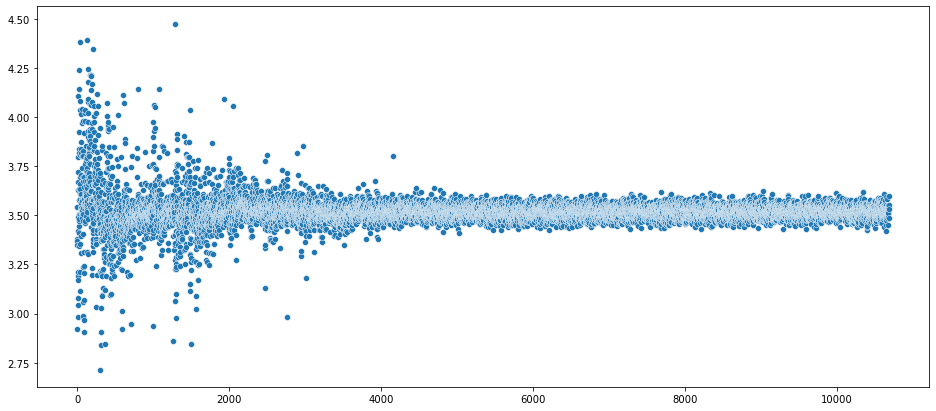

In [27]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)

In [28]:
np.percentile(funk_svd_score, [0, 25, 50, 75, 100])


array([2.71507139, 3.493482  , 3.51879631, 3.54436485, 4.4754792 ])

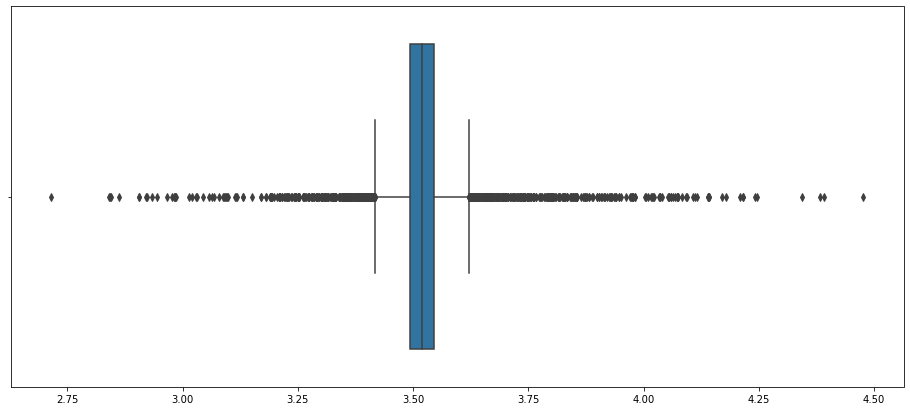

In [29]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=funk_svd_score)

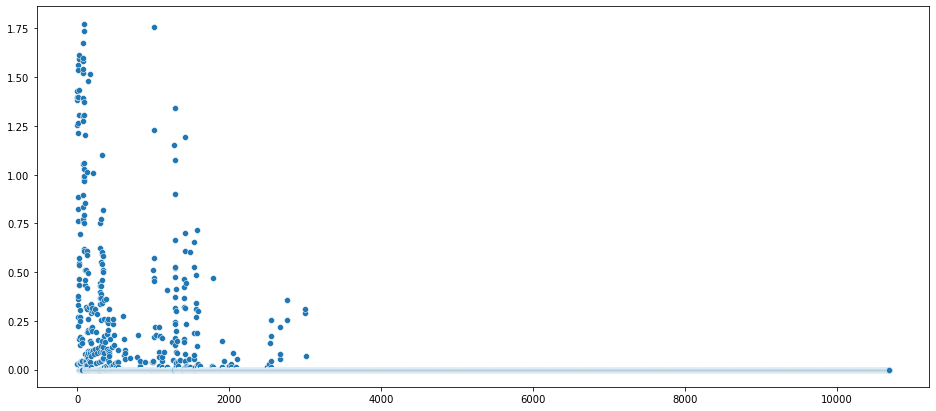

In [30]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_bpr_score)

In [31]:
np.percentile(slim_bpr_score, [0, 25, 50, 75, 100])


array([0.        , 0.        , 0.        , 0.        , 1.77471876])

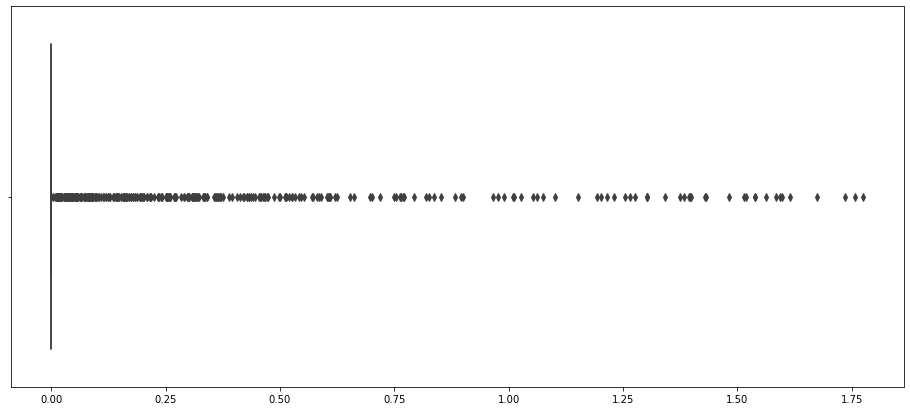

In [32]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=slim_bpr_score)

As you can see from the plots and the percentiles, the values held in each score array is totally different from one to another. 

As such, we need a way to _normalize_ these scores to be able to merge them into one.

[3.38101759 3.37078132 2.92108968 ... 3.59797302 3.4846974  3.53364231] 4.475479200696971 364.0088754371894 4.475479200696971 2.715071392321457


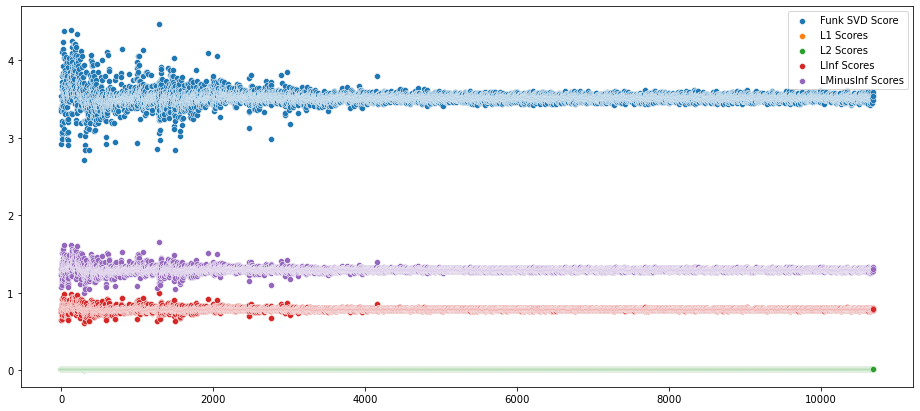

In [33]:
l1_funk_svd = LA.norm([funk_svd_score], 1)
l1_funk_svd_scores = funk_svd_score / l1_funk_svd

l2_funk_svd = LA.norm([funk_svd_score], 2)
l2_funk_svd_scores = funk_svd_score / l2_funk_svd

linf_funk_svd = LA.norm(funk_svd_score, np.inf)
linf_funk_svd_scores = funk_svd_score / linf_funk_svd

lminusinf_funk_svd = LA.norm(funk_svd_score, -np.inf)
lminusinf_funk_svd_scores = funk_svd_score / lminusinf_funk_svd

print(funk_svd_score, l1_funk_svd, l2_funk_svd, linf_funk_svd, lminusinf_funk_svd)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)
ax = sns.scatterplot(data=l1_funk_svd_scores) 
ax = sns.scatterplot(data=l2_funk_svd_scores) 
ax = sns.scatterplot(data=linf_funk_svd_scores) 
ax = sns.scatterplot(data=lminusinf_funk_svd_scores) 
ax.legend(["Funk SVD Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Similarly, we can do the same with SLIM BPR scores

[0.02890435 1.2552136  1.3844359  ... 0.         0.         0.        ] 126.3779 10.485089 1.7747188 0.0


<ipython-input-34-ed214cbf1a39>:11: RuntimeWarning: divide by zero encountered in true_divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr
<ipython-input-34-ed214cbf1a39>:11: RuntimeWarning: invalid value encountered in true_divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr


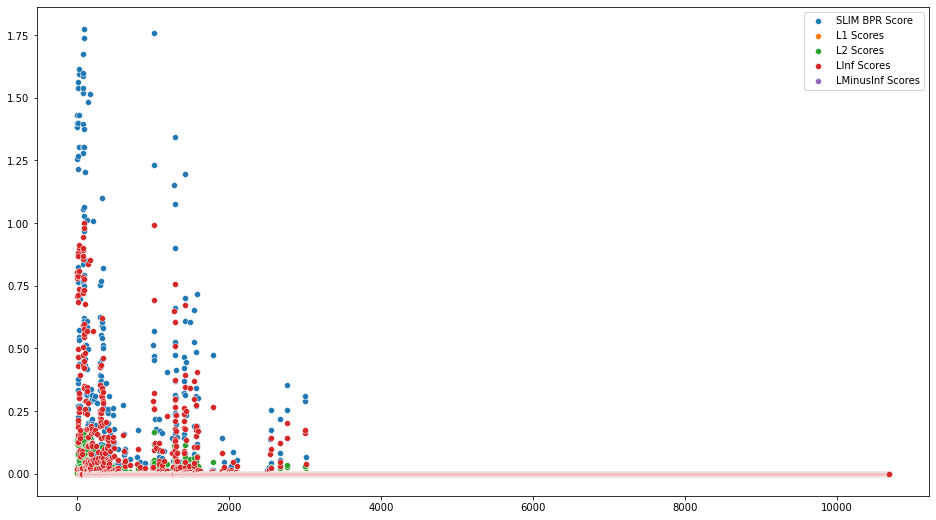

In [34]:
l1_slim_bpr = LA.norm(slim_bpr_score, 1)
l1_slim_bpr_scores = slim_bpr_score / l1_slim_bpr

l2_slim_bpr = LA.norm(slim_bpr_score, 2)
l2_slim_bpr_scores = slim_bpr_score / l2_slim_bpr

linf_slim_bpr = LA.norm(slim_bpr_score, np.inf)
linf_slim_bpr_scores = slim_bpr_score / linf_slim_bpr

lminusinf_slim_bpr = LA.norm(slim_bpr_score, -np.inf)
lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr

print(slim_bpr_score, l1_slim_bpr, l2_slim_bpr, linf_slim_bpr, lminusinf_slim_bpr)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=slim_bpr_score)
ax = sns.scatterplot(data=l1_slim_bpr_scores) 
ax = sns.scatterplot(data=l2_slim_bpr_scores) 
ax = sns.scatterplot(data=linf_slim_bpr_scores) 
ax = sns.scatterplot(data=lminusinf_slim_bpr_scores) 
ax.legend(["SLIM BPR Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now that we have *normalized* the different item score vectors, we can merge the models.

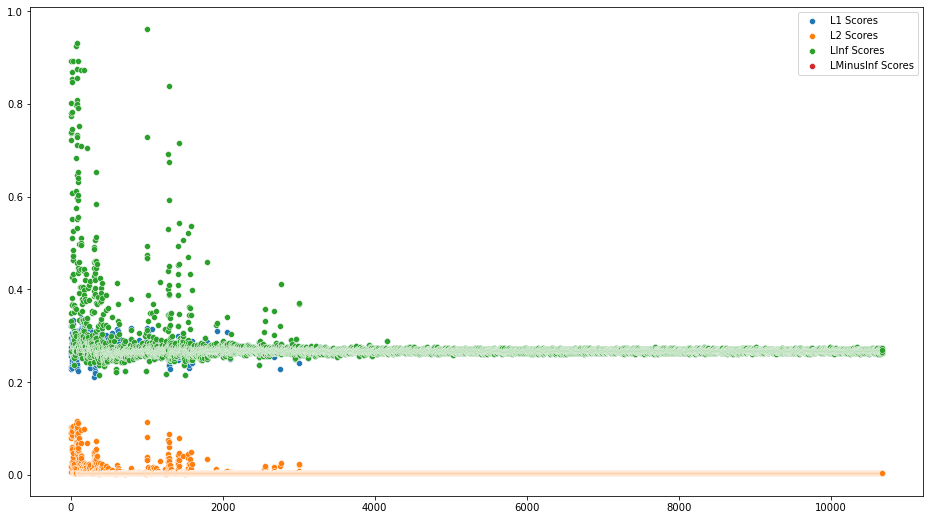

In [35]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_slim_bpr_scores + (1 - lambda_weights) * l1_funk_svd_scores
l2_new_scores = lambda_weights * l2_slim_bpr_scores + (1 - lambda_weights) * l2_funk_svd_scores
linf_new_scores = lambda_weights * linf_slim_bpr_scores + (1 - lambda_weights) * linf_funk_svd_scores
lminusinf_new_scores = lambda_weights * lminusinf_slim_bpr_scores + (1 - lambda_weights) * lminusinf_funk_svd_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now, we have everything to create our hybrid.

In [36]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [37]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, funk_svd_recommender, slim_bpr_recommender)

for norm in [1, 2, np.inf, -np.inf]:

    recommender_object.fit(norm, alpha = 0.66)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    print("Norm: {}, Result: {}".format(norm, result_df.loc[10]["MAP"]))

DifferentLossScoresHybridRecommender: URM Detected 56 ( 0.5%) items with no interactions.
EvaluatorHoldout: Processed 69646 (100.0%) in 2.85 min. Users per second: 408
Norm: 1, Result: 0.07825201278666545
EvaluatorHoldout: Processed 17000 (24.4%) in 5.02 min. Users per second: 56
EvaluatorHoldout: Processed 35000 (50.3%) in 10.04 min. Users per second: 58
EvaluatorHoldout: Processed 53000 (76.1%) in 15.10 min. Users per second: 58
EvaluatorHoldout: Processed 69646 (100.0%) in 19.73 min. Users per second: 59
Norm: 2, Result: 0.08802796876631806
EvaluatorHoldout: Processed 69646 (100.0%) in 2.79 min. Users per second: 416
Norm: inf, Result: 0.08816857780550014
EvaluatorHoldout: Processed 69646 (100.0%) in 2.85 min. Users per second: 408
Norm: -inf, Result: 0.08880076010245849


## Important note:

You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

# Some tricks, user-wise hybrids

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [38]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([15, 13, 20, ..., 94, 30, 38], dtype=int32), (69878,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [39]:
block_size = int(len(profile_length)*0.05)
block_size

3493

In [40]:
sorted_users = np.argsort(profile_length)
sorted_users

array([32755, 21863,  7680, ..., 14085, 65888, 57959], dtype=int64)

In [41]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 3493, average p.len 11.76, median 12.0, min 5, max 13
Group 1, #users in group 3493, average p.len 14.58, median 15.0, min 13, max 16
Group 2, #users in group 3493, average p.len 16.62, median 17.0, min 16, max 18
Group 3, #users in group 3493, average p.len 18.84, median 19.0, min 18, max 20
Group 4, #users in group 3493, average p.len 21.30, median 21.0, min 20, max 23
Group 5, #users in group 3493, average p.len 24.20, median 24.0, min 23, max 26
Group 6, #users in group 3493, average p.len 27.56, median 28.0, min 26, max 29
Group 7, #users in group 3493, average p.len 31.48, median 31.0, min 29, max 34
Group 8, #users in group 3493, average p.len 35.97, median 36.0, min 34, max 38
Group 9, #users in group 3493, average p.len 41.34, median 41.0, min 38, max 44
Group 10, #users in group 3493, average p.len 47.76, median 48.0, min 44, max 51
Group 11, #users in group 3493, average p.len 55.59, median 55.0, min 51, max 60
Group 12, #users in group 3493, average

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [42]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   "FunkSVD": MatrixFactorization_FunkSVD_Cython,
                                   "SLIMBPR": SLIM_BPR_Cython,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, ICM_genres)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object



TopPopRecommender: URM Detected 56 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 67565 (96.7%), 225.18 column/sec. Elapsed time 5.00 min
Similarity column 69878 (100.0%), 225.04 column/sec. Elapsed time 5.18 min
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 869.02 column/sec. Elapsed time 12.29 sec
P3alphaRecommender: URM Detected 56 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 56 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 56 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.46 sec
NMFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 5.40 min
MatrixFactorization_FunkSVD_Cython_Recomme

FUNK_SVD: Epoch 50 of 300. Elapsed time 6.56 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.33 sec. MSE loss 1.06E+00. Sample per second: 873431
FUNK_SVD: Epoch 51 of 300. Elapsed time 6.68 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.01 sec. MSE loss 1.06E+00. Sample per second: 798984
FUNK_SVD: Epoch 52 of 300. Elapsed time 6.81 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.11 sec. MSE loss 1.06E+00. Sample per second: 899703
FUNK_SVD: Epoch 53 of 300. Elapsed time 6.93 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.52 sec. MSE loss 1.05E+00. Sample per second: 850799
FUNK_SVD: Epoch 54 of 300. Elapsed time 7.05 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.75 sec. MSE loss 1.05E+00. Sample per second: 731372
FUNK_SVD: Epoch 55 of 300. Elapsed time 7.19 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.86 sec. MSE loss 1.05E+00. Sample per second: 814416
FUNK_SVD: Epoch 56 of 300. Elapsed time 7.31 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.01 sec. MSE loss 1.05E+00. Sample per second:

FUNK_SVD: Epoch 107 of 300. Elapsed time 13.91 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.65 sec. MSE loss 1.02E+00. Sample per second: 837096
FUNK_SVD: Epoch 108 of 300. Elapsed time 14.04 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.94 sec. MSE loss 1.02E+00. Sample per second: 715998
FUNK_SVD: Epoch 109 of 300. Elapsed time 14.17 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.77 sec. MSE loss 1.02E+00. Sample per second: 729656
FUNK_SVD: Epoch 110 of 300. Elapsed time 14.30 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.16 sec. MSE loss 1.02E+00. Sample per second: 784874
FUNK_SVD: Epoch 111 of 300. Elapsed time 14.43 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.39 sec. MSE loss 1.02E+00. Sample per second: 763271
FUNK_SVD: Epoch 112 of 300. Elapsed time 14.56 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.54 sec. MSE loss 1.02E+00. Sample per second: 749854
FUNK_SVD: Epoch 113 of 300. Elapsed time 14.70 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.03 sec. MSE loss 1.02E+00. Samp

FUNK_SVD: Processed 6401000 (100.0%) in 8.67 sec. MSE loss 1.01E+00. Sample per second: 737933
FUNK_SVD: Epoch 164 of 300. Elapsed time 21.19 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.08 sec. MSE loss 1.01E+00. Sample per second: 705229
FUNK_SVD: Epoch 165 of 300. Elapsed time 21.33 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.90 sec. MSE loss 1.01E+00. Sample per second: 810593
FUNK_SVD: Epoch 166 of 300. Elapsed time 21.46 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.39 sec. MSE loss 1.01E+00. Sample per second: 681418
FUNK_SVD: Epoch 167 of 300. Elapsed time 21.60 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.53 sec. MSE loss 1.01E+00. Sample per second: 850499
FUNK_SVD: Epoch 168 of 300. Elapsed time 21.72 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.72 sec. MSE loss 1.01E+00. Sample per second: 828787
FUNK_SVD: Epoch 169 of 300. Elapsed time 21.84 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.47 sec. MSE loss 1.01E+00. Sample per second: 755614
FUNK_SVD: Epoch 170 of 300. E

FUNK_SVD: Epoch 220 of 300. Elapsed time 28.40 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.33 sec. MSE loss 9.94E-01. Sample per second: 768582
FUNK_SVD: Epoch 221 of 300. Elapsed time 28.53 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.35 sec. MSE loss 9.94E-01. Sample per second: 766286
FUNK_SVD: Epoch 222 of 300. Elapsed time 28.66 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.35 sec. MSE loss 9.93E-01. Sample per second: 767006
FUNK_SVD: Epoch 223 of 300. Elapsed time 28.80 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.31 sec. MSE loss 9.93E-01. Sample per second: 769884
FUNK_SVD: Epoch 224 of 300. Elapsed time 28.93 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.14 sec. MSE loss 9.94E-01. Sample per second: 786127
FUNK_SVD: Epoch 225 of 300. Elapsed time 29.06 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.62 sec. MSE loss 9.93E-01. Sample per second: 742803
FUNK_SVD: Epoch 226 of 300. Elapsed time 29.20 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.65 sec. MSE loss 9.93E-01. Samp

FUNK_SVD: Processed 6401000 (100.0%) in 8.79 sec. MSE loss 9.83E-01. Sample per second: 728375
FUNK_SVD: Epoch 277 of 300. Elapsed time 35.89 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.66 sec. MSE loss 9.84E-01. Sample per second: 835996
FUNK_SVD: Epoch 278 of 300. Elapsed time 36.00 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.86 sec. MSE loss 9.84E-01. Sample per second: 722362
FUNK_SVD: Epoch 279 of 300. Elapsed time 36.14 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.77 sec. MSE loss 9.83E-01. Sample per second: 730253
FUNK_SVD: Epoch 280 of 300. Elapsed time 36.27 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.85 sec. MSE loss 9.82E-01. Sample per second: 722792
FUNK_SVD: Epoch 281 of 300. Elapsed time 36.41 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.45 sec. MSE loss 9.84E-01. Sample per second: 756985
FUNK_SVD: Epoch 282 of 300. Elapsed time 36.53 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.81 sec. MSE loss 9.84E-01. Sample per second: 819289
FUNK_SVD: Epoch 283 of 300. E

Processed 69878 (100.0%) in 0.96 sec. BPR loss is 2.41E-02. Sample per second: 73017
SLIM_BPR_Recommender: Epoch 31 of 300. Elapsed time 22.38 sec
Processed 69878 (100.0%) in 1.58 sec. BPR loss is 2.48E-02. Sample per second: 44284
SLIM_BPR_Recommender: Epoch 32 of 300. Elapsed time 23.00 sec
Processed 69878 (100.0%) in 1.34 sec. BPR loss is 2.55E-02. Sample per second: 52056
SLIM_BPR_Recommender: Epoch 33 of 300. Elapsed time 23.76 sec
Processed 69878 (100.0%) in 1.05 sec. BPR loss is 2.66E-02. Sample per second: 66653
SLIM_BPR_Recommender: Epoch 34 of 300. Elapsed time 24.47 sec
Processed 69878 (100.0%) in 0.92 sec. BPR loss is 2.68E-02. Sample per second: 76237
SLIM_BPR_Recommender: Epoch 35 of 300. Elapsed time 25.34 sec
Processed 69878 (100.0%) in 1.66 sec. BPR loss is 2.78E-02. Sample per second: 42100
SLIM_BPR_Recommender: Epoch 36 of 300. Elapsed time 26.08 sec
Processed 69878 (100.0%) in 1.26 sec. BPR loss is 2.82E-02. Sample per second: 55509
SLIM_BPR_Recommender: Epoch 37 of

Processed 69878 (100.0%) in 0.99 sec. BPR loss is 6.47E-02. Sample per second: 70458
SLIM_BPR_Recommender: Epoch 87 of 300. Elapsed time 1.04 min
Processed 69878 (100.0%) in 1.59 sec. BPR loss is 6.54E-02. Sample per second: 43843
SLIM_BPR_Recommender: Epoch 88 of 300. Elapsed time 1.05 min
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 6.72E-02. Sample per second: 58732
SLIM_BPR_Recommender: Epoch 89 of 300. Elapsed time 1.06 min
Processed 69878 (100.0%) in 1.02 sec. BPR loss is 6.82E-02. Sample per second: 68466
SLIM_BPR_Recommender: Epoch 90 of 300. Elapsed time 1.07 min
Processed 69878 (100.0%) in 0.66 sec. BPR loss is 6.79E-02. Sample per second: 105244
SLIM_BPR_Recommender: Epoch 91 of 300. Elapsed time 1.08 min
Processed 69878 (100.0%) in 1.26 sec. BPR loss is 6.86E-02. Sample per second: 55487
SLIM_BPR_Recommender: Epoch 92 of 300. Elapsed time 1.09 min
Processed 69878 (100.0%) in 0.88 sec. BPR loss is 6.96E-02. Sample per second: 79073
SLIM_BPR_Recommender: Epoch 93 of 300.

Processed 69878 (100.0%) in 0.93 sec. BPR loss is 1.05E-01. Sample per second: 75314
SLIM_BPR_Recommender: Epoch 143 of 300. Elapsed time 1.67 min
Processed 69878 (100.0%) in 1.60 sec. BPR loss is 1.04E-01. Sample per second: 43670
SLIM_BPR_Recommender: Epoch 144 of 300. Elapsed time 1.68 min
Processed 69878 (100.0%) in 1.37 sec. BPR loss is 1.06E-01. Sample per second: 50955
SLIM_BPR_Recommender: Epoch 145 of 300. Elapsed time 1.70 min
Processed 69878 (100.0%) in 1.06 sec. BPR loss is 1.06E-01. Sample per second: 65821
SLIM_BPR_Recommender: Epoch 146 of 300. Elapsed time 1.71 min
Processed 69878 (100.0%) in 0.78 sec. BPR loss is 1.07E-01. Sample per second: 88916
SLIM_BPR_Recommender: Epoch 147 of 300. Elapsed time 1.72 min
Processed 69878 (100.0%) in 1.40 sec. BPR loss is 1.09E-01. Sample per second: 49904
SLIM_BPR_Recommender: Epoch 148 of 300. Elapsed time 1.73 min
Processed 69878 (100.0%) in 1.01 sec. BPR loss is 1.08E-01. Sample per second: 68938
SLIM_BPR_Recommender: Epoch 149 o

Processed 69878 (100.0%) in 1.52 sec. BPR loss is 1.40E-01. Sample per second: 46055
SLIM_BPR_Recommender: Epoch 199 of 300. Elapsed time 2.35 min
Processed 69878 (100.0%) in 1.44 sec. BPR loss is 1.42E-01. Sample per second: 48549
SLIM_BPR_Recommender: Epoch 200 of 300. Elapsed time 2.36 min
Processed 69878 (100.0%) in 1.09 sec. BPR loss is 1.43E-01. Sample per second: 63836
SLIM_BPR_Recommender: Epoch 201 of 300. Elapsed time 2.38 min
Processed 69878 (100.0%) in 0.91 sec. BPR loss is 1.43E-01. Sample per second: 76385
SLIM_BPR_Recommender: Epoch 202 of 300. Elapsed time 2.39 min
Processed 69878 (100.0%) in 1.88 sec. BPR loss is 1.45E-01. Sample per second: 37173
SLIM_BPR_Recommender: Epoch 203 of 300. Elapsed time 2.40 min
Processed 69878 (100.0%) in 1.81 sec. BPR loss is 1.46E-01. Sample per second: 38588
SLIM_BPR_Recommender: Epoch 204 of 300. Elapsed time 2.42 min
Processed 69878 (100.0%) in 1.46 sec. BPR loss is 1.47E-01. Sample per second: 47920
SLIM_BPR_Recommender: Epoch 205 o

Processed 69878 (100.0%) in 1.30 sec. BPR loss is 1.78E-01. Sample per second: 53629
SLIM_BPR_Recommender: Epoch 255 of 300. Elapsed time 3.03 min
Processed 69878 (100.0%) in 1.18 sec. BPR loss is 1.81E-01. Sample per second: 58865
SLIM_BPR_Recommender: Epoch 256 of 300. Elapsed time 3.04 min
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 1.78E-01. Sample per second: 58816
SLIM_BPR_Recommender: Epoch 257 of 300. Elapsed time 3.06 min
Processed 69878 (100.0%) in 0.82 sec. BPR loss is 1.78E-01. Sample per second: 85108
SLIM_BPR_Recommender: Epoch 258 of 300. Elapsed time 3.07 min
Processed 69878 (100.0%) in 1.56 sec. BPR loss is 1.78E-01. Sample per second: 44872
SLIM_BPR_Recommender: Epoch 259 of 300. Elapsed time 3.08 min
Processed 69878 (100.0%) in 1.52 sec. BPR loss is 1.81E-01. Sample per second: 45782
SLIM_BPR_Recommender: Epoch 260 of 300. Elapsed time 3.10 min
Processed 69878 (100.0%) in 1.42 sec. BPR loss is 1.82E-01. Sample per second: 49216
SLIM_BPR_Recommender: Epoch 261 o

In [43]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 3493, average p.len 11.76, median 12.0, min 5, max 13
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3491 (100.0%) in 6.52 sec. Users per second: 535
EvaluatorHoldout: Processed 3491 (100.0%) in 6.67 sec. Users per second: 524
EvaluatorHoldout: Processed 3491 (100.0%) in 6.16 sec. Users per second: 566
EvaluatorHoldout: Processed 3491 (100.0%) in 6.30 sec. Users per second: 554
EvaluatorHoldout: Processed 3491 (100.0%) in 6.32 sec. Users per second: 553
EvaluatorHoldout: Processed 3491 (100.0%) in 6.53 sec. Users per second: 534
EvaluatorHoldout: Processed 3491 (100.0%) in 8.72 sec. Users per second: 400
EvaluatorHoldout: Processed 3491 (100.0%) in 6.84 sec. Users per second: 510
EvaluatorHoldout: Processed 3491 (100.0%) in 7.06 sec. Users per second: 494
EvaluatorHoldout: Processed 3491 (100.0%) in 6.01 sec. Users per second: 581
EvaluatorHoldout: Process

EvaluatorHoldout: Processed 3492 (100.0%) in 4.98 sec. Users per second: 701
EvaluatorHoldout: Processed 3492 (100.0%) in 7.18 sec. Users per second: 487
EvaluatorHoldout: Processed 3492 (100.0%) in 7.18 sec. Users per second: 486
Group 8, #users in group 3493, average p.len 35.97, median 36.0, min 34, max 38
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 (100.0%) in 7.80 sec. Users per second: 448
EvaluatorHoldout: Processed 3493 (100.0%) in 6.13 sec. Users per second: 569
EvaluatorHoldout: Processed 3493 (100.0%) in 7.45 sec. Users per second: 469
EvaluatorHoldout: Processed 3493 (100.0%) in 7.26 sec. Users per second: 481
EvaluatorHoldout: Processed 3493 (100.0%) in 7.51 sec. Users per second: 465
EvaluatorHoldout: Processed 3493 (100.0%) in 5.57 sec. Users per second: 628
EvaluatorHoldout: Processed 3493 (100.0%) in 10.12 sec. Users per second: 345
EvaluatorHoldout: Proce

EvaluatorHoldout: Processed 3493 (100.0%) in 6.41 sec. Users per second: 545
EvaluatorHoldout: Processed 3493 (100.0%) in 10.52 sec. Users per second: 332
EvaluatorHoldout: Processed 3493 (100.0%) in 6.58 sec. Users per second: 531
EvaluatorHoldout: Processed 3493 (100.0%) in 7.16 sec. Users per second: 488
EvaluatorHoldout: Processed 3493 (100.0%) in 6.64 sec. Users per second: 526
EvaluatorHoldout: Processed 3493 (100.0%) in 8.54 sec. Users per second: 409
Group 16, #users in group 3493, average p.len 140.42, median 140.0, min 124, max 159
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 (100.0%) in 6.50 sec. Users per second: 537
EvaluatorHoldout: Processed 3493 (100.0%) in 7.51 sec. Users per second: 465
EvaluatorHoldout: Processed 3493 (100.0%) in 7.29 sec. Users per second: 479
EvaluatorHoldout: Processed 3493 (100.0%) in 7.08 sec. Users per second: 493
EvaluatorHoldout: 

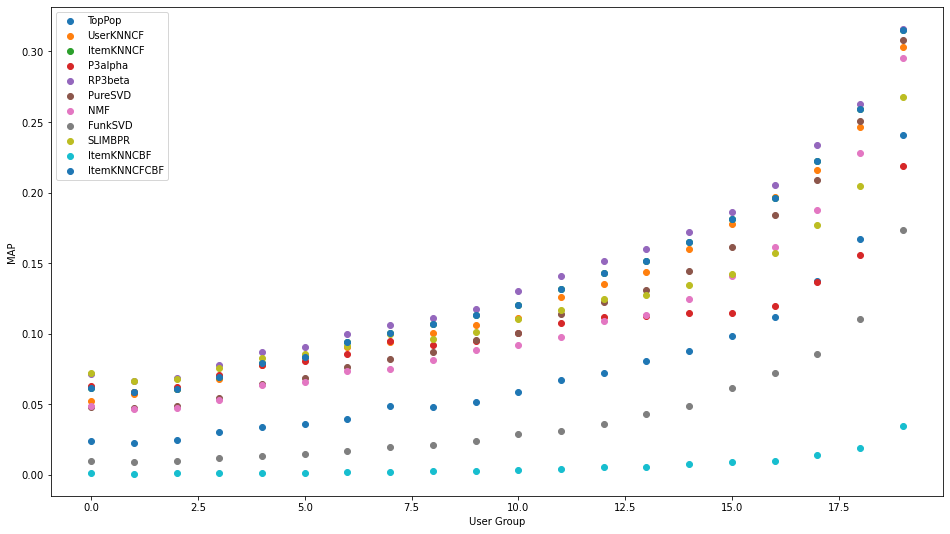

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types